So we know from Notebook 10 that trying to make it learn one set of logits per batch is good and gets features right.

How can we make the logits consistent over batches?

Will collect the gradients and gumbel selected values after 5 epochs in each mode. The two modes will be the behavior before burn-in and the behavior after mode-in.

Will follow Notebook 10 with slight modifications (described right before). Remember in Notebook 10, we explored behaviors when all the features were real vs when half the features were noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 50
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(14, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(17, device='cuda:0')
tensor(16, device='cuda:0')


add noiise

In [7]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[ 0.0013,  0.0135,  0.0054,  ..., -0.0047,  0.0033, -0.0097],
        [ 0.0080, -0.0057,  0.0010,  ...,  0.0009, -0.0134,  0.0105],
        [-0.0103, -0.0029,  0.0185,  ..., -0.0133, -0.0037,  0.0134],
        ...,
        [ 0.0073, -0.0149, -0.0108,  ..., -0.0047, -0.0137,  0.0070],
        [ 0.0006, -0.0141, -0.0124,  ..., -0.0085,  0.0069, -0.0110],
        [-0.0159,  0.0177, -0.0087,  ..., -0.0076, -0.0009,  0.0078]],
       device='cuda:0')

In [8]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [9]:
actual_data.shape

torch.Size([10000, 60])

In [10]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [11]:
global_t = 1

Example of what worked before

In [12]:
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [13]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = D)
    if vae_gumbel_truncated.t >= 0.01:
        vae_gumbel_truncated.t *= 0.75
    if epoch > 5 and epoch <25:
        gradients_before_burnin += grads
    if epoch == 25:
        with torch.no_grad():
            # collect a version of the select keys at this point
            w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
            subset_indices_before_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()
    if epoch > 24:
        gradient_post_burn_in += grads
        
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices_post_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()

Train Epoch: 1 [0/8000 (0%)]	Loss: 21.246294
Train Epoch: 1 [1280/8000 (16%)]	Loss: 20.250397
Train Epoch: 1 [2560/8000 (32%)]	Loss: 19.305346
Train Epoch: 1 [3840/8000 (48%)]	Loss: 18.313152
Train Epoch: 1 [5120/8000 (64%)]	Loss: 17.451023
Train Epoch: 1 [6400/8000 (80%)]	Loss: 16.190554
Train Epoch: 1 [7680/8000 (96%)]	Loss: 14.823248
====> Epoch: 1 Average loss: 18.0863
Train Epoch: 2 [0/8000 (0%)]	Loss: 13.966923
Train Epoch: 2 [1280/8000 (16%)]	Loss: 13.805084
Train Epoch: 2 [2560/8000 (32%)]	Loss: 13.408572
Train Epoch: 2 [3840/8000 (48%)]	Loss: 13.038525
Train Epoch: 2 [5120/8000 (64%)]	Loss: 12.352503
Train Epoch: 2 [6400/8000 (80%)]	Loss: 12.367773
Train Epoch: 2 [7680/8000 (96%)]	Loss: 11.958294
====> Epoch: 2 Average loss: 13.1279
Train Epoch: 3 [0/8000 (0%)]	Loss: 12.673205
Train Epoch: 3 [1280/8000 (16%)]	Loss: 12.181462
Train Epoch: 3 [2560/8000 (32%)]	Loss: 12.358383
Train Epoch: 3 [3840/8000 (48%)]	Loss: 12.377422
Train Epoch: 3 [5120/8000 (64%)]	Loss: 12.426563
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 10.782840
Train Epoch: 22 [7680/8000 (96%)]	Loss: 10.292208
====> Epoch: 22 Average loss: 10.6665
Train Epoch: 23 [0/8000 (0%)]	Loss: 10.157126
Train Epoch: 23 [1280/8000 (16%)]	Loss: 10.540656
Train Epoch: 23 [2560/8000 (32%)]	Loss: 10.753371
Train Epoch: 23 [3840/8000 (48%)]	Loss: 10.622337
Train Epoch: 23 [5120/8000 (64%)]	Loss: 10.741127
Train Epoch: 23 [6400/8000 (80%)]	Loss: 10.701597
Train Epoch: 23 [7680/8000 (96%)]	Loss: 10.534987
====> Epoch: 23 Average loss: 10.6281
Train Epoch: 24 [0/8000 (0%)]	Loss: 10.502141
Train Epoch: 24 [1280/8000 (16%)]	Loss: 10.684061
Train Epoch: 24 [2560/8000 (32%)]	Loss: 10.734015
Train Epoch: 24 [3840/8000 (48%)]	Loss: 10.379245
Train Epoch: 24 [5120/8000 (64%)]	Loss: 10.957211
Train Epoch: 24 [6400/8000 (80%)]	Loss: 10.496857
Train Epoch: 24 [7680/8000 (96%)]	Loss: 10.607121
====> Epoch: 24 Average loss: 10.6134
Train Epoch: 25 [0/8000 (0%)]	Loss: 10.293395
Train Epoch: 25 [1280/8000 (16%)]	Loss: 10.52864

Train Epoch: 44 [1280/8000 (16%)]	Loss: 10.093376
Train Epoch: 44 [2560/8000 (32%)]	Loss: 10.071982
Train Epoch: 44 [3840/8000 (48%)]	Loss: 10.949146
Train Epoch: 44 [5120/8000 (64%)]	Loss: 10.586852
Train Epoch: 44 [6400/8000 (80%)]	Loss: 10.686936
Train Epoch: 44 [7680/8000 (96%)]	Loss: 10.196752
====> Epoch: 44 Average loss: 10.4038
Train Epoch: 45 [0/8000 (0%)]	Loss: 10.245931
Train Epoch: 45 [1280/8000 (16%)]	Loss: 10.678970
Train Epoch: 45 [2560/8000 (32%)]	Loss: 10.351840
Train Epoch: 45 [3840/8000 (48%)]	Loss: 10.163573
Train Epoch: 45 [5120/8000 (64%)]	Loss: 10.464585
Train Epoch: 45 [6400/8000 (80%)]	Loss: 10.633328
Train Epoch: 45 [7680/8000 (96%)]	Loss: 10.427898
====> Epoch: 45 Average loss: 10.3855
Train Epoch: 46 [0/8000 (0%)]	Loss: 10.302140
Train Epoch: 46 [1280/8000 (16%)]	Loss: 10.518029
Train Epoch: 46 [2560/8000 (32%)]	Loss: 10.528069
Train Epoch: 46 [3840/8000 (48%)]	Loss: 9.742825
Train Epoch: 46 [5120/8000 (64%)]	Loss: 10.304817
Train Epoch: 46 [6400/8000 (80%)]

tensor(1.4094e+12, device='cuda:0')
tensor(8.1824e+11, device='cuda:0')


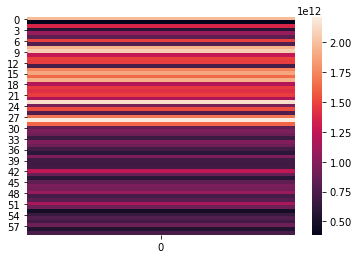

In [14]:
print(gradients_before_burnin[:D].mean())
print(gradients_before_burnin[D:].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(5.2290e+12, device='cuda:0')
tensor(2.3107e+12, device='cuda:0')


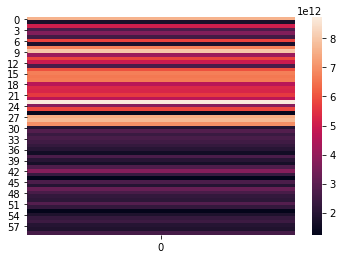

In [15]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(4.4557)
tensor(3.5443)


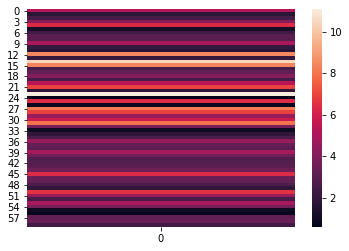

In [16]:
print(subset_indices_before_burnin.sum(dim = 0)[:D].mean())
print(subset_indices_before_burnin.sum(dim = 0)[D:].mean())
sns.heatmap(subset_indices_before_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

tensor(4.3393)
tensor(3.6607)


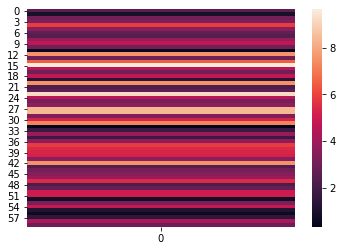

In [17]:
print(subset_indices_post_burnin.sum(dim = 0)[:D].mean())
print(subset_indices_post_burnin.sum(dim = 0)[(D):].mean())
sns.heatmap(subset_indices_post_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [18]:
subset_indices_post_burnin.sum(dim = 0)[:(D//2)].sum() - subset_indices_post_burnin.sum(dim = 0)[(D//2):].sum()

tensor(-132.5392)

The new model


In [31]:
logits_changed_loss_lambda = 0.001
alpha = 0.99

In [32]:
vae_gumbel_truncated = VAE_Gumbel_NInstaState(2*D, 100, 20, k = 3*z_size, t = global_t, alpha = alpha)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [33]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients_gumbel_state(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D,
                                                      logits_changed_loss_lambda=logits_changed_loss_lambda,
                                                      DEBUG = True)
    
    if vae_gumbel_truncated.t >= 0.01:
        vae_gumbel_truncated.t *= 0.75
    if epoch > 5 and epoch <25:
        gradients_before_burnin += grads
    if epoch == 25:
        with torch.no_grad():
            # collect a version of the select keys at this point
            print("GUMBEL DEBUG")
            w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
            subset_indices_before_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()
        
        print("BURN IN DEBUG")
        vae_gumbel_truncated.set_burned_in()
        #vae_gumbel_truncated.t /= 10
        print("Going post burn in")
    if epoch > 24:
        gradient_post_burn_in += grads
        
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices_post_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.636711
Train Epoch: 1 [1280/8000 (16%)]	Loss: 40.889404
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.506477
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.583241
Loss tensor(2443.5161, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(151111.0625, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 1 [5120/8000 (64%)]	Loss: 40.506248
Train Epoch: 1 [6400/8000 (80%)]	Loss: 40.270187
Train Epoch: 1 [7680/8000 (96%)]	Loss: 39.868652
====> Epoch: 1 Average loss: 40.5388
Train Epoch: 2 [0/8000 (0%)]	Loss: 39.685799
Loss tensor(2246.3579, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(287279.5625, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 2 [1280/8000 (16%)]	Loss: 39.519001
Train Epoch: 2 [2560/8000 (32%)]	Loss: 39.506393
Train Epoch: 2 [3840/8000 (48%)]	Loss: 39.369644
Loss tensor(2154.0349, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(392307.0312, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 2 

Train Epoch: 15 [7680/8000 (96%)]	Loss: 1547.486572
====> Epoch: 15 Average loss: 1624.3490
Train Epoch: 16 [0/8000 (0%)]	Loss: 1486.859985
Train Epoch: 16 [1280/8000 (16%)]	Loss: 1411.335815
Train Epoch: 16 [2560/8000 (32%)]	Loss: 1265.579102
Train Epoch: 16 [3840/8000 (48%)]	Loss: 1073.827393
Train Epoch: 16 [5120/8000 (64%)]	Loss: 982.957275
Train Epoch: 16 [6400/8000 (80%)]	Loss: 797.142578
Train Epoch: 16 [7680/8000 (96%)]	Loss: 577.638550
====> Epoch: 16 Average loss: 1091.1001
Train Epoch: 17 [0/8000 (0%)]	Loss: 539.138611
Train Epoch: 17 [1280/8000 (16%)]	Loss: 442.694550
Train Epoch: 17 [2560/8000 (32%)]	Loss: 416.514099
Train Epoch: 17 [3840/8000 (48%)]	Loss: 348.600464
Train Epoch: 17 [5120/8000 (64%)]	Loss: 246.966003
Train Epoch: 17 [6400/8000 (80%)]	Loss: 185.770126
Loss tensor(2085.5183, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5919759., device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 17 [7680/8000 (96%)]	Loss: 131.395920
====> Epoch: 17 Averag

Train Epoch: 29 [1280/8000 (16%)]	Loss: 31.857977
Train Epoch: 29 [2560/8000 (32%)]	Loss: 31.338472
Train Epoch: 29 [3840/8000 (48%)]	Loss: 31.889994
Train Epoch: 29 [5120/8000 (64%)]	Loss: 31.408375
Train Epoch: 29 [6400/8000 (80%)]	Loss: 31.540146
Loss tensor(2028.6022, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 29 [7680/8000 (96%)]	Loss: 31.721056
====> Epoch: 29 Average loss: 31.7238
Train Epoch: 30 [0/8000 (0%)]	Loss: 31.862036
Train Epoch: 30 [1280/8000 (16%)]	Loss: 31.701244
Train Epoch: 30 [2560/8000 (32%)]	Loss: 31.611795
Train Epoch: 30 [3840/8000 (48%)]	Loss: 31.625719
Train Epoch: 30 [5120/8000 (64%)]	Loss: 31.237616
Train Epoch: 30 [6400/8000 (80%)]	Loss: 31.634947
Loss tensor(2044.2118, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 30 [7680/8000 (96%)]	Loss: 31.976173
====> Epoch: 30 Average loss: 31.6972
Train Epoch: 31 [0/8000 (0%)]	Loss: 31.514114
Train Epoch: 31 [1280/8000 (16%)]	Loss: 32.215267
Train Epoch: 31 [2560/8000 (

Train Epoch: 46 [5120/8000 (64%)]	Loss: 31.505136
Train Epoch: 46 [6400/8000 (80%)]	Loss: 31.767614
Loss tensor(2002.2354, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 46 [7680/8000 (96%)]	Loss: 31.946699
====> Epoch: 46 Average loss: 31.5225
Train Epoch: 47 [0/8000 (0%)]	Loss: 31.543314
Train Epoch: 47 [1280/8000 (16%)]	Loss: 31.224676
Loss tensor(2027.9631, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 47 [2560/8000 (32%)]	Loss: 30.901382
Loss tensor(2006.0098, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 47 [3840/8000 (48%)]	Loss: 31.319536
Train Epoch: 47 [5120/8000 (64%)]	Loss: 31.424980
Train Epoch: 47 [6400/8000 (80%)]	Loss: 31.640083
Loss tensor(2006.7357, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 47 [7680/8000 (96%)]	Loss: 31.972843
====> Epoch: 47 Average loss: 31.5120
Train Epoch: 48 [0/8000 (0%)]	Loss: 31.319674
Train Epoch: 48 [1280/8000 (16%)]	Loss: 31.746866
Train Epoch: 48 [2560/80

tensor(4149947., device='cuda:0')
tensor(4275082., device='cuda:0')


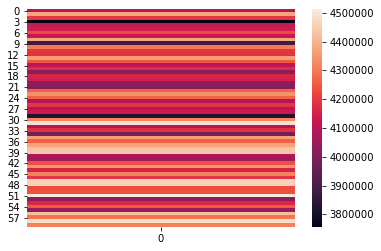

In [34]:
print(gradients_before_burnin[:(D)].mean())
print(gradients_before_burnin[(D):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(107762.7812, device='cuda:0')
tensor(61190.8750, device='cuda:0')


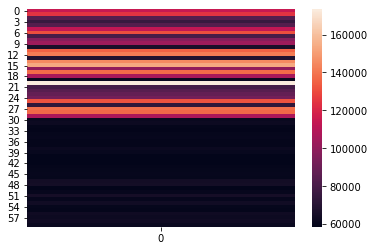

In [35]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(4.3395)
tensor(3.6605)


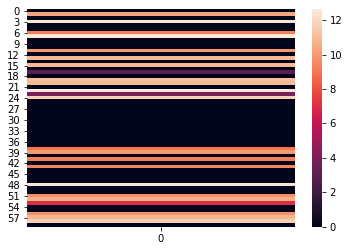

In [36]:
print(subset_indices_before_burnin.sum(dim = 0)[:D].mean())
print(subset_indices_before_burnin.sum(dim = 0)[D:].mean())
sns.heatmap(subset_indices_before_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

tensor(4.4679)
tensor(3.5321)


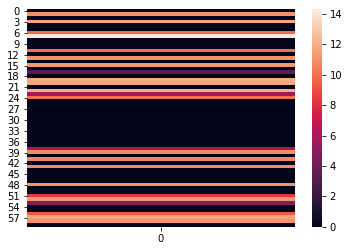

In [37]:
print(subset_indices_post_burnin.sum(dim = 0)[:D].mean())
print(subset_indices_post_burnin.sum(dim = 0)[D:].mean())
sns.heatmap(subset_indices_post_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [38]:
(subset_indices_post_burnin.sum(dim = 0)[:(D//2)] > 0).sum()

tensor(6)

In [39]:
(subset_indices_post_burnin.sum(dim = 0)[(D//2):] > 0).sum()

tensor(18)

In [40]:
subset_indices_post_burnin.sum(dim = 0)[:(D//2)]

tensor([ 0.0000, 11.0484,  0.0000, 11.7654,  0.0000,  0.0000,  9.7939, 14.2957,
         0.0000,  0.0000,  0.0000, 10.0000,  0.0000, 10.9934,  0.0000])

In [41]:
subset_indices_post_burnin.sum(dim = 0)[(D//2):]

tensor([11.2781,  0.0000,  3.3372,  0.0000, 11.9030, 11.7429,  0.0000, 12.0195,
         5.8595,  9.9998,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.0255,
        10.8775,  0.0000, 10.6982,  0.0000, 10.8898,  0.0000,  0.0000,  0.0000,
         0.0000, 11.1083,  0.0000,  0.0000,  8.3744, 11.1767,  4.7406,  0.0000,
         0.0000,  9.3591, 11.6559, 11.0574,  0.0000])

In [42]:
subset_indices_post_burnin.sum(dim = 0)[:(D//2)].sum() - subset_indices_post_burnin.sum(dim = 0)[(D//2):].sum()

tensor(-104.2064)